Now that we have gone through a manual process of modeling our dataset, let's see if we can replicate this using an Automated workflow. As a reminder, our plan of action was as follows:

1. Perform EDA on the dataset to extract valuable insight about the process generating the time series **(COMPLETED)**.
2. Build a baseline model (univariable model without exogenous variables) for benchmarking purposes **(COMPLETED)**.
3. Build a univariate model with all exogenous variables to check best possible performance **(COMPLETED)**.
4. Evaluate the model with exogenous variables and discuss any potential issues **(COMPLETED)**.
5. Overcome issues identified above **(COMPLETED)**.
6. Make future predictions with the best model **(COMPLETED)**.
7. Replicate flow with Automated Time Series Modeling (AutoML) **(Covered in this notebook)**

In [1]:
# Only enable critical logging (Optional)
import os
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

In [2]:
def what_is_installed():
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except ModuleNotFoundError:
    !pip install pycaret
    what_is_installed()


System:
    python: 3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)]
executable: C:\Users\Nikhil\.conda\envs\pycaret_dev_sktime_0p11_2\python.exe
   machine: Windows-10-10.0.19044-SP0

PyCaret required dependencies:


C:\Users\Nikhil\.conda\envs\pycaret_dev_sktime_0p11_2\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


                 pip: 21.2.2
          setuptools: 61.2.0
             pycaret: 3.0.0
             ipython: Not installed
          ipywidgets: 7.7.0
               numpy: 1.21.6
              pandas: 1.4.2
              jinja2: 3.1.2
               scipy: 1.8.0
              joblib: 1.1.0
             sklearn: 1.0.2
                pyod: Installed but version unavailable
            imblearn: 0.9.0
   category_encoders: 2.4.1
            lightgbm: 3.3.2
               numba: 0.55.1
            requests: 2.27.1
          matplotlib: 3.5.2
          scikitplot: 0.3.7
         yellowbrick: 1.4
              plotly: 5.8.0
             kaleido: 0.2.1
         statsmodels: 0.13.2
              sktime: 0.11.4
               tbats: Installed but version unavailable
            pmdarima: 1.8.5

PyCaret optional dependencies:
                shap: Not installed
           interpret: Not installed
                umap: Not installed
    pandas_profiling: Not installed
  explainerdashboard: Not i

In [3]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

In [4]:
# Global Figure Settings for notebook ----
global_fig_settings = {"renderer": "notebook", "width": 1000, "height": 600}

In [5]:
data = get_data("airquality", verbose=False)
data["index"] = pd.to_datetime(data["Date"] + " " + data["Time"])
data.drop(columns=["Date", "Time"], inplace=True)
data.replace(-200, np.nan, inplace=True)
data.set_index("index", inplace=True)

target = "CO(GT)"
exog_vars = ['NOx(GT)', 'PT08.S3(NOx)', 'RH']
include = [target] + exog_vars
data = data[include]
data.head()

CO(GT)  NOx(GT)  PT08.S3(NOx)    RH
index                                                   
2004-03-10 18:00:00     2.6    166.0        1056.0  48.9
2004-03-10 19:00:00     2.0    103.0        1174.0  47.7
2004-03-10 20:00:00     2.2    131.0        1140.0  54.0
2004-03-10 21:00:00     2.2    172.0        1092.0  60.0
2004-03-10 22:00:00     1.6    131.0        1205.0  59.6

# Step 7: AutoML

In [6]:
FH=48
metric = "mase"
exclude = ["auto_arima", "bats", "tbats", "lar_cds_dt", "par_cds_dt"]

# Step 7A: Univariate AutoML with and without Exogenous Variables

In [7]:
exp_auto = TSForecastingExperiment()

# enforce_exogenous=False --> Use multivariate forecasting when model supports it, else use univariate forecasting
exp_auto.setup(
    data=data, target=target, fh=FH, enforce_exogenous=False,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, session_id=42
)

In [8]:
# # Check available models ----
# exp_auto_noexo.models()

In [9]:
# Include slower models like Prophet (turbo=False), but exclude some specific models ----
best = exp_auto.compare_models(sort=metric, turbo=False, exclude=exclude)

In [10]:
exp_auto.plot_model(best)

In [11]:
final_auto_model = exp_auto.finalize_model(best)

In [14]:
def safe_predict(exp, model):
    """Prediction wrapper for demo purposes."""
    try: 
        future_preds = exp.predict_model(model)
    except ValueError as exception:
        print(exception)
        exo_vars = exp.exogenous_variables
        print(f"{len(exo_vars)} exogenous variables (X) needed in order to make future predictions:\n{exo_vars}")
        
        
        exog_exps = []
        exog_models = []
        for exog_var in exog_vars:
            exog_exp = TSForecastingExperiment()
            exog_exp.setup(
                data=data[exog_var], fh=FH,
                numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
                fig_kwargs=global_fig_settings, session_id=42
            )

            # Users can customize how to model future exogenous variables i.e. add
            # more steps and models to potentially get better models at the expense
            # of higher modeling time.
            best = exog_exp.compare_models(
                sort=metric, include=["arima", "ets", "exp_smooth", "theta", "lightgbm_cds_dt",]        
            )
            final_exog_model = exog_exp.finalize_model(best)

            exog_exps.append(exog_exp)
            exog_models.append(final_exog_model)

        # Step 2: Get future predictions for exog variables ----
        future_exog = [
            exog_exp.predict_model(exog_model)
            for exog_exp, exog_model in zip(exog_exps, exog_models)
        ]
        future_exog = pd.concat(future_exog, axis=1)
        future_exog.columns = exog_vars
        
        future_preds = exp.predict_model(model, X=future_exog)
    
    return future_preds      

<AxesSubplot:>

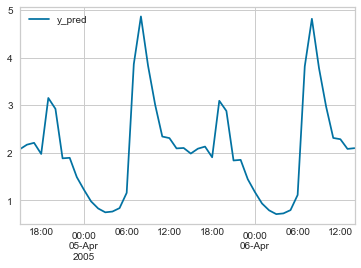

In [15]:
future_preds = safe_predict(exp_auto, final_auto_model)
future_preds.plot()